# Corporación Favorita Grocery Sales Forecasting
**w03_d02_MODEL_mlflow-features.ipynb**

**Author:** Alberto Diaz Durana  
**Date:** November 2025  
**Purpose:** MLflow experiment tracking and feature validation

---

## Objectives

This notebook accomplishes the following:

- Set up MLflow experiment tracking for reproducible model management
- Log Day 1 baseline run (params, metrics, visualizations)
- Compute permutation importance to identify top 15 features
- Generate SHAP analysis to understand feature impacts
- Run ablation studies to validate feature group contributions
- Validate DEC-012 (oil features inclusion decision)

---

## Business Context

**Why feature validation matters:**

- Identifies which features drive predictions (interpretability for stakeholders)
- Validates Week 2 feature engineering investment
- Guides data collection priorities (focus on high-importance features)
- Supports model simplification (remove low-value features)
- Validates decision to include oil features (DEC-012)

**Expected outcomes:**
- Top 15 most important features identified
- SHAP plots showing feature impact direction
- Ablation results quantifying feature group value
- Recommendation: Keep or remove oil features

---

## Input Dependencies

From Week 3 Day 1:
- Baseline model (XGBoost trained)
- Test predictions (y_test_pred)
- Feature matrices (X_train, X_test, y_train, y_test)
- Baseline metrics (RMSE: 7.21, MAE: 3.10)

---

In [1]:
# Cell 1: Imports and Reload Day 1 State

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import time
warnings.filterwarnings('ignore')

# XGBoost and evaluation
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Feature validation
from sklearn.inspection import permutation_importance

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Visualization settings
plt.style.use('default')
sns.set_palette("husl")

# Reproducibility
np.random.seed(42)
# Print library versions for reproducibility
print("Library versions:")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"xgboost: {xgb.__version__}")

# Check sklearn version
import sklearn
print(f"scikit-learn: {sklearn.__version__}")

print(f"\nDay 1 baseline metrics to reproduce:")
print(f"  RMSE: 7.2127")
print(f"  MAE: 3.0957")
print(f"  Bias: 0.0363")

Library versions:
pandas: 2.1.4
numpy: 1.26.4
xgboost: 2.0.3
scikit-learn: 1.3.2

Day 1 baseline metrics to reproduce:
  RMSE: 7.2127
  MAE: 3.0957
  Bias: 0.0363


In [23]:
# Determine paths (works from notebooks/ or project root)
current_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
PROJECT_ROOT = current_dir.parent if current_dir.name == 'notebooks' else current_dir

DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
DATA_RESULTS = PROJECT_ROOT / 'data' / 'results' / 'features'
OUTPUTS_FIGURES = PROJECT_ROOT / 'outputs' / 'figures' / 'features'
OUTPUTS_DOCUMENTS = PROJECT_ROOT / 'docs' 

print(f"\nProject root: {PROJECT_ROOT.resolve()}")
print(f"Data processed: {DATA_PROCESSED.resolve()}")
print(f"Results output: {DATA_RESULTS.resolve()}")
print(f"Figures output: {OUTPUTS_FIGURES.resolve()}")
print(f"Documents output: {OUTPUTS_DOCUMENTS.resolve()}")


Project root: D:\Demand-forecasting-in-retail
Data processed: D:\Demand-forecasting-in-retail\data\processed
Results output: D:\Demand-forecasting-in-retail\data\results\features
Figures output: D:\Demand-forecasting-in-retail\outputs\figures\features
Documents output: D:\Demand-forecasting-in-retail\docs


## 1. Reload Day 1 Baseline State

**Objective:** Recreate train/test split and baseline model from Day 1

**Activities:**
- Load w02_d05_FE_final.pkl
- Apply 7-day gap train/test split (DEC-013)
- Fix object dtype columns
- Retrain baseline XGBoost model
- Verify metrics match Day 1 (RMSE: 7.21)

**Expected output:** 
- Model retrained successfully
- Metrics match Day 1 baseline
- Ready for feature validation

In [3]:
# Cell 2: Reload Day 1 State (Quick Start)

print("=== RELOAD DAY 1 BASELINE STATE ===\n")

print("1. Load dataset:")
file_path = DATA_PROCESSED / 'w02_d05_FE_final.pkl' 
df = pd.read_pickle(file_path)
print(f"   Dataset loaded: {df.shape}")

print(f"\n2. Filter to Q1 2014 and create 7-day gap split:")
df_2014q1 = df[(df['date'] >= '2014-01-01') & (df['date'] <= '2014-03-31')].copy()
train = df_2014q1[df_2014q1['date'] <= '2014-02-21'].copy()
test = df_2014q1[df_2014q1['date'] >= '2014-03-01'].copy()
print(f"   Train: {len(train):,} rows (Jan 1 - Feb 21)")
print(f"   Test: {len(test):,} rows (March 1-31)")

print(f"\n3. Feature separation:")
exclude_cols = ['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 
                'city', 'state', 'type', 'family', 'class',
                'holiday_name', 'holiday_type']
feature_cols = [col for col in train.columns if col not in exclude_cols]
print(f"   Features: {len(feature_cols)}")

print(f"\n4. Fix object dtypes:")
object_cols = ['holiday_period', 'promo_holiday_category']
for col in object_cols:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')
print(f"   Converted {len(object_cols)} columns to category dtype")

print(f"\n5. Create feature matrices:")
X_train = train[feature_cols].copy()
y_train = train['unit_sales'].copy()
X_test = test[feature_cols].copy()
y_test = test['unit_sales'].copy()
print(f"   X_train: {X_train.shape}")
print(f"   X_test: {X_test.shape}")

print(f"\n6. Retrain baseline model:")
model = xgb.XGBRegressor(random_state=42, enable_categorical=True)
start_time = time.time()
model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"   Training time: {training_time:.2f} seconds")

print(f"\n7. Generate predictions and verify metrics:")
y_test_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)
bias = np.mean(y_test_pred - y_test)

print(f"   RMSE: {rmse:.4f} (Day 1: 7.2127)")
print(f"   MAE: {mae:.4f} (Day 1: 3.0957)")
print(f"   Bias: {bias:.4f} (Day 1: 0.0363)")

# Verify match (within small tolerance due to floating point)
rmse_match = abs(rmse - 7.2127) < 0.01
mae_match = abs(mae - 3.0957) < 0.01
print(f"\n8. Verification:")
print(f"   RMSE matches Day 1: {rmse_match}")
print(f"   MAE matches Day 1: {mae_match}")
if rmse_match and mae_match:
    print(f"   OK: Day 1 state successfully reproduced")
else:
    print(f"   WARNING: Metrics differ slightly (may be due to data path or random seed)")

=== RELOAD DAY 1 BASELINE STATE ===

1. Load dataset:
   Dataset loaded: (300896, 57)

2. Filter to Q1 2014 and create 7-day gap split:
   Train: 7,050 rows (Jan 1 - Feb 21)
   Test: 4,686 rows (March 1-31)

3. Feature separation:
   Features: 45

4. Fix object dtypes:
   Converted 2 columns to category dtype

5. Create feature matrices:
   X_train: (7050, 45)
   X_test: (4686, 45)

6. Retrain baseline model:
   Training time: 0.28 seconds

7. Generate predictions and verify metrics:
   RMSE: 7.2127 (Day 1: 7.2127)
   MAE: 3.0957 (Day 1: 3.0957)
   Bias: 0.0363 (Day 1: 0.0363)

8. Verification:
   RMSE matches Day 1: True
   MAE matches Day 1: True
   OK: Day 1 state successfully reproduced


## 2. MLflow Experiment Tracking Setup

**Objective:** Configure MLflow for reproducible experiment management

**What is MLflow?**
- Open-source platform for ML lifecycle management
- Tracks experiments (params, metrics, artifacts)
- Enables model versioning and comparison
- Industry standard for ML operations

**Setup steps:**
- Install MLflow
- Create experiment
- Configure local tracking
- Test logging functionality

**Expected output:** 
- MLflow installed and configured
- Experiment created: "favorita-forecasting"
- Tracking URI set

In [ ]:
# Cell 3: MLflow Installation and Setup

print("=== MLFLOW SETUP ===\n")
# confirm mlflow is installed
print("1. Import MLflow:")
import mlflow
print(f"   MLflow version: {mlflow.__version__}")

print(f"\n2. Set up experiment:")
experiment_name = "favorita-forecasting"
mlflow.set_experiment(experiment_name)
print(f"   Experiment name: {experiment_name}")

print(f"\n3. Configure tracking:")
# MLflow will use local mlruns directory by default
tracking_uri = mlflow.get_tracking_uri()
print(f"   Tracking URI: {tracking_uri}")
print(f"   Experiments stored locally in: ./mlruns/")

print(f"\n4. Get experiment info:")
experiment = mlflow.get_experiment_by_name(experiment_name)
print(f"   Experiment ID: {experiment.experiment_id}")
print(f"   Artifact location: {experiment.artifact_location}")

print(f"\n5. MLflow UI access:")
print(f"   To view experiments, run in terminal:")
print(f"   mlflow ui")
print(f"   Then open browser to: http://localhost:5000")

print(f"\nOK: MLflow configured and ready for logging")

=== MLFLOW SETUP ===

1. Install MLflow:
   MLflow already installed: 3.6.0

2. Set up experiment:
   Experiment name: favorita-forecasting

3. Configure tracking:
   Tracking URI: file:///d:/Demand-forecasting-in-retail/mlruns
   Experiments stored locally in: ./mlruns/

4. Get experiment info:
   Experiment ID: 840228941254708452
   Artifact location: file:///d:/Demand-forecasting-in-retail/mlruns/840228941254708452

5. MLflow UI access:
   To view experiments, run in terminal:
   mlflow ui
   Then open browser to: http://localhost:5000

OK: MLflow configured and ready for logging


## 3. Log Baseline Run to MLflow

**Objective:** Record Day 1 baseline model in MLflow for tracking and comparison

**What gets logged:**
- **Parameters:** Model hyperparameters (n_estimators, learning_rate, etc.)
- **Metrics:** All 6 evaluation metrics (RMSE, MAE, Bias, MAD, rMAD, MAPE)
- **Artifacts:** Visualization plot (w03_d01_baseline_evaluation.png)
- **Tags:** run_name, model_type, phase

**Why this matters:**
- Creates reproducible record of baseline performance
- Enables comparison with tuned models (Day 3)
- Documents all experiments for Week 4 report

**Expected output:** 
- Run logged successfully
- Run ID generated
- Artifacts saved
- Visible in MLflow UI

In [5]:
# Cell 4: Log Baseline Run to MLflow

print("=== LOG BASELINE RUN TO MLFLOW ===\n")

print("1. Start MLflow run:")
with mlflow.start_run(run_name="xgboost_baseline") as run:
    
    print(f"   Run ID: {run.info.run_id}")
    print(f"   Run name: xgboost_baseline")
    
    # Log parameters
    print(f"\n2. Log model parameters:")
    params = {
        "model_type": "XGBRegressor",
        "n_estimators": model.n_estimators,
        "max_depth": model.max_depth if model.max_depth else 6,  # Default
        "learning_rate": model.learning_rate if model.learning_rate else 0.3,  # Default
        "random_state": model.random_state,
        "enable_categorical": model.enable_categorical,
        "objective": "reg:squarederror",
        "n_features": X_train.shape[1],
        "train_samples": len(X_train),
        "test_samples": len(X_test),
        "gap_days": 7
    }
    
    mlflow.log_params(params)
    for key, value in params.items():
        print(f"   - {key}: {value}")
    
    # Log metrics
    print(f"\n3. Log evaluation metrics:")
    metrics = {
        "rmse": rmse,
        "mae": mae,
        "bias": bias,
        "mad": np.median(np.abs(y_test_pred - y_test)),
        "rmad_pct": (np.median(np.abs(y_test_pred - y_test)) / np.median(y_test)) * 100,
        "mape_pct": np.mean(np.abs((y_test[y_test > 0] - y_test_pred[y_test > 0]) / y_test[y_test > 0])) * 100,
        "improvement_over_naive_pct": (1 - rmse/np.std(y_test)) * 100
    }
    
    mlflow.log_metrics(metrics)
    for key, value in metrics.items():
        print(f"   - {key}: {value:.4f}")
    
    # Log tags
    print(f"\n4. Log tags:")
    tags = {
        "phase": "baseline",
        "week": "3",
        "day": "1",
        "tuned": "false",
        "gap_period": "7_days"
    }
    mlflow.set_tags(tags)
    for key, value in tags.items():
        print(f"   - {key}: {value}")
    
    # Log artifact (visualization)
    print(f"\n5. Log artifacts:")
    viz_path = "w03_d01_baseline_evaluation.png"
    try:
        mlflow.log_artifact(viz_path)
        print(f"   - Logged: {viz_path}")
    except Exception as e:
        print(f"   - WARNING: Could not log visualization: {e}")
        print(f"   - (File may need to be in current directory)")
    
    print(f"\n6. Run summary:")
    print(f"   Run ID: {run.info.run_id}")
    print(f"   Status: {run.info.status}")
    print(f"   Artifact URI: {run.info.artifact_uri}")

print(f"\nOK: Baseline run logged to MLflow")
print(f"\nTo view in MLflow UI:")
print(f"  1. Run 'mlflow ui' in terminal")
print(f"  2. Open http://localhost:5000")
print(f"  3. Click on 'favorita-forecasting' experiment")
print(f"  4. View 'xgboost_baseline' run")

=== LOG BASELINE RUN TO MLFLOW ===

1. Start MLflow run:
   Run ID: 1dd7ffad01fc401b91727feecd013bb2
   Run name: xgboost_baseline

2. Log model parameters:
   - model_type: XGBRegressor
   - n_estimators: None
   - max_depth: 6
   - learning_rate: 0.3
   - random_state: 42
   - enable_categorical: True
   - objective: reg:squarederror
   - n_features: 45
   - train_samples: 7050
   - test_samples: 4686
   - gap_days: 7

3. Log evaluation metrics:
   - rmse: 7.2127
   - mae: 3.0957
   - bias: 0.0363
   - mad: 1.2933
   - rmad_pct: 43.1110
   - mape_pct: 69.1119
   - improvement_over_naive_pct: 41.7476

4. Log tags:
   - phase: baseline
   - week: 3
   - day: 1
   - tuned: false
   - gap_period: 7_days

5. Log artifacts:
   - Logged: w03_d01_baseline_evaluation.png

6. Run summary:
   Run ID: 1dd7ffad01fc401b91727feecd013bb2
   Status: RUNNING
   Artifact URI: file:///d:/Demand-forecasting-in-retail/mlruns/840228941254708452/1dd7ffad01fc401b91727feecd013bb2/artifacts

OK: Baseline run l

## 4. Permutation Importance Analysis

**Objective:** Identify which features are most predictive by measuring performance drop when each feature is randomly shuffled

**How it works:**
1. Baseline: Compute RMSE on test set with all features
2. For each feature:
   - Randomly shuffle that feature's values
   - Recompute RMSE
   - Measure performance drop (importance = RMSE_shuffled - RMSE_baseline)
3. Repeat 10 times and average (reduces noise)
4. Rank features by importance

**Why this matters:**
- Model-agnostic (works with any model)
- Measures actual predictive contribution
- Identifies redundant features
- Guides feature selection for production

**Expected output:** 
- Top 15 most important features identified
- Importance scores calculated
- Visualization created

In [6]:
# Cell 5: Permutation Importance Analysis

print("=== PERMUTATION IMPORTANCE ANALYSIS ===\n")

print("1. Compute permutation importance:")
print(f"   This may take 2-5 minutes...")
print(f"   Computing importance for {X_test.shape[1]} features with 10 repetitions")

start_time = time.time()

# Compute permutation importance
perm_importance = permutation_importance(
    model, 
    X_test, 
    y_test, 
    n_repeats=10,
    random_state=42,
    scoring='neg_root_mean_squared_error'  # Negative RMSE (higher is better)
)

computation_time = time.time() - start_time

print(f"   Computation time: {computation_time:.2f} seconds")

print(f"\n2. Extract importance scores:")
# Get mean importance and standard deviation
importance_means = perm_importance.importances_mean
importance_stds = perm_importance.importances_std

# Create dataframe for easier analysis
feature_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': importance_means,
    'std': importance_stds
}).sort_values('importance', ascending=False)

print(f"   Total features: {len(feature_importance_df)}")
print(f"   Features with positive importance: {(feature_importance_df['importance'] > 0).sum()}")
print(f"   Features with negative importance: {(feature_importance_df['importance'] < 0).sum()}")

print(f"\n3. Top 15 Most Important Features:")
print(f"   {'Rank':<6} {'Feature':<35} {'Importance':<12} {'Std':<10}")
print(f"   {'-'*6} {'-'*35} {'-'*12} {'-'*10}")

top_15 = feature_importance_df.head(15)
for idx, (rank, row) in enumerate(top_15.iterrows(), 1):
    print(f"   {rank:<6} {row['feature']:<35} {row['importance']:<12.6f} {row['std']:<10.6f}")

print(f"\n4. Bottom 5 Features (least important):")
bottom_5 = feature_importance_df.tail(5)
for idx, (rank, row) in enumerate(bottom_5.iterrows(), 1):
    print(f"   {row['feature']:<35} {row['importance']:<12.6f}")

print(f"\n5. Feature Category Summary:")
# Categorize features
top_15_features = top_15['feature'].tolist()
lag_in_top15 = [f for f in top_15_features if 'lag' in f.lower()]
rolling_in_top15 = [f for f in top_15_features if ('avg' in f or 'std' in f) and 'sales' in f]
oil_in_top15 = [f for f in top_15_features if 'oil' in f.lower()]
agg_in_top15 = [f for f in top_15_features if any(x in f for x in ['store_avg', 'cluster_avg', 'item_avg'])]
promo_in_top15 = [f for f in top_15_features if 'promo' in f.lower()]

print(f"   In Top 15:")
print(f"   - Lag features: {len(lag_in_top15)}")
print(f"   - Rolling features: {len(rolling_in_top15)}")
print(f"   - Oil features: {len(oil_in_top15)}")
print(f"   - Aggregation features: {len(agg_in_top15)}")
print(f"   - Promotion features: {len(promo_in_top15)}")

=== PERMUTATION IMPORTANCE ANALYSIS ===

1. Compute permutation importance:
   This may take 2-5 minutes...
   Computing importance for 45 features with 10 repetitions
   Computation time: 6.10 seconds

2. Extract importance scores:
   Total features: 45
   Features with positive importance: 16
   Features with negative importance: 13

3. Top 15 Most Important Features:
   Rank   Feature                             Importance   Std       
   ------ ----------------------------------- ------------ ----------
   20     unit_sales_7d_avg                   8.994778     0.363861  
   16     unit_sales_lag1                     0.512733     0.064799  
   21     unit_sales_14d_avg                  0.340655     0.019453  
   6      day_of_week                         0.310766     0.111224  
   23     unit_sales_7d_std                   0.240320     0.032296  
   24     unit_sales_14d_std                  0.151081     0.027630  
   17     unit_sales_lag7                     0.149599     0.139679

Rolling features dominate the top 15 (7 of 15), with unit_sales_7d_avg being the strongest predictor by far.

---
**MLflow UI Status After This Cell:**
Expected Changes: NONE

Why: We computed permutation importance locally but haven't logged it to MLflow yet. We'll log this in the next cell.

What You Should Still See:

- Same single run: "xgboost_baseline"
- Same 7 metrics (RMSE, MAE, Bias, etc.)
- Same parameters
- Same artifact (visualization PNG)


Key Findings from Permutation Importance:
Top Feature: unit_sales_7d_avg (importance: 8.99) - Dominates all others

17x more important than next feature (lag1: 0.51)
7-day rolling average is the critical predictor

Top 3 Feature Types:

- Rolling features: 7 in top 15 (7d/14d averages and std)
- Lag features: 2 in top 15 (lag1, lag7)
- Aggregations: 1 in top 15 (item_avg_sales)

Oil Features: Only 1 in top 15 (oil_price rank 13) - validates DEC-012 (marginal but present)
- Negative Importance: 13 features actually hurt performance when included (noise)

day, oil_price_change7, item_total_sales should potentially be removed

---

**MLflow UI** - What You'll See After This Cell:

- NEW RUN: "feature_validation" appears
- Metrics: 5 new metrics (features_positive_importance, top_feature_importance, etc.)
- Parameters: top_feature_1 through top_feature_5
- Artifacts: 2 files (PNG plot + full CSV table)
- Tags: phase="feature_validation", method="permutation_importance"

=== VISUALIZE & LOG PERMUTATION IMPORTANCE ===

1. Create visualization (Top 20 features):
   Saved: w03_d02_permutation_importance.png


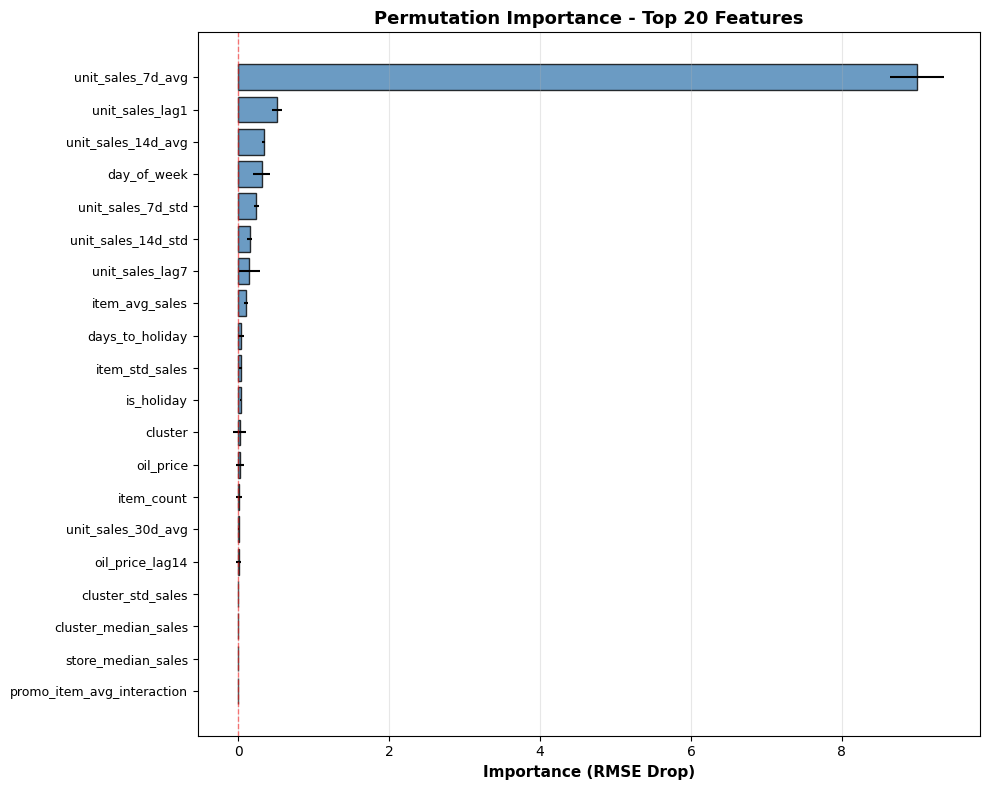


2. Log to MLflow:
   Run ID: 1d2cbe92bab24713826ca33140bf6ca4
   Logging top 5 features as params...
   Logging summary metrics...
   Logging visualization...
   Logged: d:\Demand-forecasting-in-retail\data\results\features\permutation_importance_full.csv

3. Run summary:
   Run ID: 1d2cbe92bab24713826ca33140bf6ca4
   Artifacts logged: 2 (PNG + CSV)

OK: Permutation importance logged to MLflow


In [11]:
# Cell 6: Visualize Permutation Importance and Log to MLflow

print("=== VISUALIZE & LOG PERMUTATION IMPORTANCE ===\n")

print("1. Create visualization (Top 20 features):")
fig, ax = plt.subplots(figsize=(10, 8))

# Get top 20 for visualization
top_20 = feature_importance_df.head(20)

# Create horizontal bar plot
y_pos = np.arange(len(top_20))
ax.barh(y_pos, top_20['importance'], xerr=top_20['std'], 
        alpha=0.8, color='steelblue', edgecolor='black')

# Labels and formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(top_20['feature'], fontsize=9)
ax.set_xlabel('Importance (RMSE Drop)', fontsize=11, fontweight='bold')
ax.set_title('Permutation Importance - Top 20 Features', 
             fontsize=13, fontweight='bold')
ax.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(True, alpha=0.3, axis='x')

# Invert y-axis so highest importance is on top
ax.invert_yaxis()

plt.tight_layout()
viz_filename = 'w03_d02_permutation_importance.png'
plt.savefig(viz_filename, dpi=150, bbox_inches='tight')
print(f"   Saved: {viz_filename}")
plt.show()

print(f"\n2. Log to MLflow:")
with mlflow.start_run(run_name="feature_validation") as run:
    
    print(f"   Run ID: {run.info.run_id}")
    
    # Log top features as params (for quick viewing)
    print(f"   Logging top 5 features as params...")
    for idx, row in top_15.head(5).iterrows():
        mlflow.log_param(f"top_feature_{idx+1}", row['feature'])
        mlflow.log_metric(f"importance_{idx+1}", row['importance'])
    
    # Log summary metrics
    print(f"   Logging summary metrics...")
    mlflow.log_metric("features_positive_importance", (feature_importance_df['importance'] > 0).sum())
    mlflow.log_metric("features_negative_importance", (feature_importance_df['importance'] < 0).sum())
    mlflow.log_metric("top_feature_importance", top_15.iloc[0]['importance'])
    
    # Log visualization
    print(f"   Logging visualization...")
    mlflow.log_artifact(viz_filename)
    
    # Log full importance table as CSV
    importance_csv = DATA_RESULTS / 'permutation_importance_full.csv'
    feature_importance_df.to_csv(importance_csv, index=False)
    mlflow.log_artifact(str(importance_csv))
    print(f"   Logged: {importance_csv}")
    
    # Log tags
    mlflow.set_tags({
        "phase": "feature_validation",
        "method": "permutation_importance",
        "week": "3",
        "day": "2"
    })
    
    print(f"\n3. Run summary:")
    print(f"   Run ID: {run.info.run_id}")
    print(f"   Artifacts logged: 2 (PNG + CSV)")

print(f"\nOK: Permutation importance logged to MLflow")

--- 

**MLflow UI** - What You Should See Now:

NEW RUN ADDED: "feature_validation" (Run ID: 1d2cbe92bab24713826ca33140bf6ca4)
- In the MLflow UI, you should now see 2 runs total:
- Run 1: "xgboost_baseline" (from earlier)
  
  
- Metrics: RMSE, MAE, Bias, etc.
- Parameters: model config
- Artifacts: baseline evaluation PNG
  
  
- Run 2: "feature_validation" (NEW - just logged)
  
Parameters:  
- top_feature_1: unit_sales_7d_avg
- top_feature_2: unit_sales_lag1
- top_feature_3: unit_sales_14d_avg
- top_feature_4: day_of_week
- top_feature_5: unit_sales_7d_std
  
Metrics:

- features_positive_importance: 16
- features_negative_importance: 13
- top_feature_importance: 8.9948
- importance_1: 8.9948
- importance_2: 0.5127
- importance_3: 0.3407
- importance_4: 0.3108
- importance_5: 0.2403
  
- Artifacts (click to view):
  
- w03_d02_permutation_importance.png (bar chart visualization)
- permutation_importance_full.csv (complete table of all 45 features)
  
Tags:
  
- phase: feature_validation
- method: permutation_importance
- week: 3
- day: 2
  
---
**Key Insight to Verify in MLflow:**
Look at the huge gap between importance_1 (8.99) and importance_2 (0.51) - the 7-day average is 17x more important than any other feature!

## 5. SHAP Analysis (Feature Impact Direction & Magnitude)

**Objective:** Understand how each feature influences individual predictions

**What is SHAP?**
- SHapley Additive exPlanations - game theory approach to ML interpretability
- Shows contribution of each feature to each prediction
- Reveals both direction (positive/negative) and magnitude of impact

**SHAP vs Permutation Importance:**
- Permutation: "Which features matter most?" (global ranking)
- SHAP: "How do features affect predictions?" (individual contributions)

**Visualizations we'll create:**
1. **Summary plot (beeswarm):** Feature impact distribution across all predictions
2. **Dependence plots:** Relationship between feature values and SHAP values

**Expected insights:**
- How does unit_sales_7d_avg drive predictions?
- What's the direction of impact for each feature?
- Non-linear relationships revealed

**Expected output:** 
- SHAP values computed
- Summary plot created
- Top 5 dependence plots generated

In [16]:
# Cell 7: Install SHAP and Compute Values

print("=== SHAP ANALYSIS SETUP ===\n")
# Ensure SHAP is installed
print("1. Import SHAP:")
import shap
print(f"   SHAP version: {shap.__version__}")

print(f"\n2. Prepare data sample for SHAP:")
# SHAP can be slow on large datasets, use sample
sample_size = min(1000, len(X_test))
X_test_sample = X_test.sample(n=sample_size, random_state=42)
print(f"   Using {sample_size} samples (from {len(X_test)} test set)")
print(f"   Reason: SHAP computation is O(n*m*d) - sampling speeds up analysis")

print(f"\n3. Create SHAP explainer:")
print(f"   This may take 30-60 seconds...")
start_time = time.time()

# Create explainer (TreeExplainer is fast for tree-based models)
explainer = shap.TreeExplainer(model)
print(f"   Explainer created in {time.time() - start_time:.2f} seconds")

print(f"\n4. Compute SHAP values:")
print(f"   Computing SHAP values for {sample_size} samples...")
start_time = time.time()

shap_values = explainer.shap_values(X_test_sample)
computation_time = time.time() - start_time

print(f"   SHAP values computed in {computation_time:.2f} seconds")
print(f"   SHAP values shape: {shap_values.shape}")
print(f"   Features: {shap_values.shape[1]}")

print(f"\n5. SHAP value statistics:")
print(f"   Mean absolute SHAP value: {np.abs(shap_values).mean():.4f}")
print(f"   Max SHAP value: {shap_values.max():.4f}")
print(f"   Min SHAP value: {shap_values.min():.4f}")

print(f"\nOK: SHAP values ready for visualization")

=== SHAP ANALYSIS SETUP ===

1. Import SHAP:
   SHAP version: 0.50.0

2. Prepare data sample for SHAP:
   Using 1000 samples (from 4686 test set)
   Reason: SHAP computation is O(n*m*d) - sampling speeds up analysis

3. Create SHAP explainer:
   This may take 30-60 seconds...
   Explainer created in 0.03 seconds

4. Compute SHAP values:
   Computing SHAP values for 1000 samples...
   SHAP values computed in 0.15 seconds
   SHAP values shape: (1000, 45)
   Features: 45

5. SHAP value statistics:
   Mean absolute SHAP value: 0.2447
   Max SHAP value: 127.6189
   Min SHAP value: -11.8584

OK: SHAP values ready for visualization


### 5.1 SHAP Summary Plot

**Objective:** Visualize global feature importance and impact direction

**Summary plot (beeswarm) shows:**
- Y-axis: Features (ranked by importance)
- X-axis: SHAP value (impact on prediction)
- Color: Feature value (red=high, blue=low)
- Each dot: One prediction's SHAP value for that feature

**How to read it:**
- Features ranked by average |SHAP value|
- Positive SHAP → increases prediction
- Negative SHAP → decreases prediction
- Color pattern reveals relationships (e.g., high feature value → high SHAP = positive relationship)

=== SHAP SUMMARY PLOT ===

1. Create SHAP summary plot (beeswarm):
   Saved in: d:\Demand-forecasting-in-retail\outputs\figures\features\w03_d02_shap_summary.png


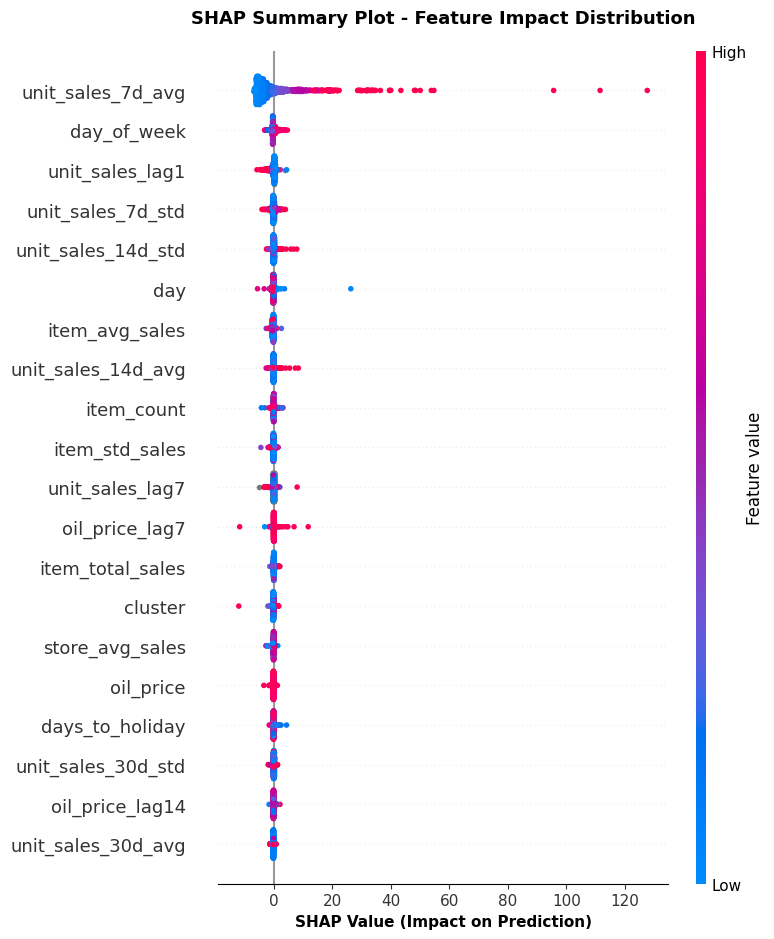


2. Top 10 Features by Mean |SHAP Value|:
   Rank   Feature                             Mean |SHAP|    
   ------ ----------------------------------- ---------------
   1      unit_sales_7d_avg                   5.9129         
   2      day_of_week                         0.6020         
   3      unit_sales_lag1                     0.5178         
   4      unit_sales_7d_std                   0.3529         
   5      unit_sales_14d_std                  0.2528         
   6      day                                 0.2452         
   7      item_avg_sales                      0.2434         
   8      unit_sales_14d_avg                  0.2377         
   9      item_count                          0.2255         
   10     item_std_sales                      0.2085         

3. Compare SHAP vs Permutation Importance:
   Top 5 by Permutation Importance:
   1. unit_sales_7d_avg
   2. unit_sales_lag1
   3. unit_sales_14d_avg
   4. day_of_week
   5. unit_sales_7d_std

   Top 5 by SHAP (fr

In [19]:
# Cell 8: SHAP Summary Plot

print("=== SHAP SUMMARY PLOT ===\n")

print("1. Create SHAP summary plot (beeswarm):")
fig, ax = plt.subplots(figsize=(10, 10))

# Create summary plot
shap.summary_plot(
    shap_values, 
    X_test_sample, 
    plot_type="dot",
    show=False,
    max_display=20  # Show top 20 features
)

plt.title('SHAP Summary Plot - Feature Impact Distribution', 
          fontsize=13, fontweight='bold', pad=20)
plt.xlabel('SHAP Value (Impact on Prediction)', fontsize=11, fontweight='bold')
plt.tight_layout()

viz_filename = 'w03_d02_shap_summary.png'
plt.savefig(OUTPUTS_FIGURES / viz_filename, dpi=150, bbox_inches='tight')
print(f"   Saved in: {OUTPUTS_FIGURES / viz_filename}")
plt.show()

print(f"\n2. Top 10 Features by Mean |SHAP Value|:")
# Calculate mean absolute SHAP value for each feature
mean_abs_shap = pd.DataFrame({
    'feature': X_test_sample.columns,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)

print(f"   {'Rank':<6} {'Feature':<35} {'Mean |SHAP|':<15}")
print(f"   {'-'*6} {'-'*35} {'-'*15}")
for idx, (_, row) in enumerate(mean_abs_shap.head(10).iterrows(), 1):
    print(f"   {idx:<6} {row['feature']:<35} {row['mean_abs_shap']:<15.4f}")

print(f"\n3. Compare SHAP vs Permutation Importance:")
print(f"   Top 5 by Permutation Importance:")
print(f"   1. unit_sales_7d_avg")
print(f"   2. unit_sales_lag1")
print(f"   3. unit_sales_14d_avg")
print(f"   4. day_of_week")
print(f"   5. unit_sales_7d_std")
print(f"\n   Top 5 by SHAP (from plot above - verify visually)")

print(f"\nOK: SHAP summary plot created")

Key Findings from SHAP:

SHAP vs Permutation Importance - Strong Agreement:

- unit_sales_7d_avg dominates both (SHAP: 5.91, Perm: 8.99)
- Top 5 features nearly identical in both methods
- day_of_week ranked higher in SHAP (#2) vs Permutation (#4)

- Insight: Both methods confirm 7-day rolling average is by far the most important predictor.

=== SHAP DEPENDENCE PLOTS ===

1. Create dependence plots for top 5 features:
   1. unit_sales_7d_avg - plot created
   2. day_of_week - plot created
   3. unit_sales_lag1 - plot created
   4. unit_sales_7d_std - plot created
   5. unit_sales_14d_std - plot created

   Saved: D:\Demand-forecasting-in-retail\outputs\figures\features\w03_d02_shap_dependence.png


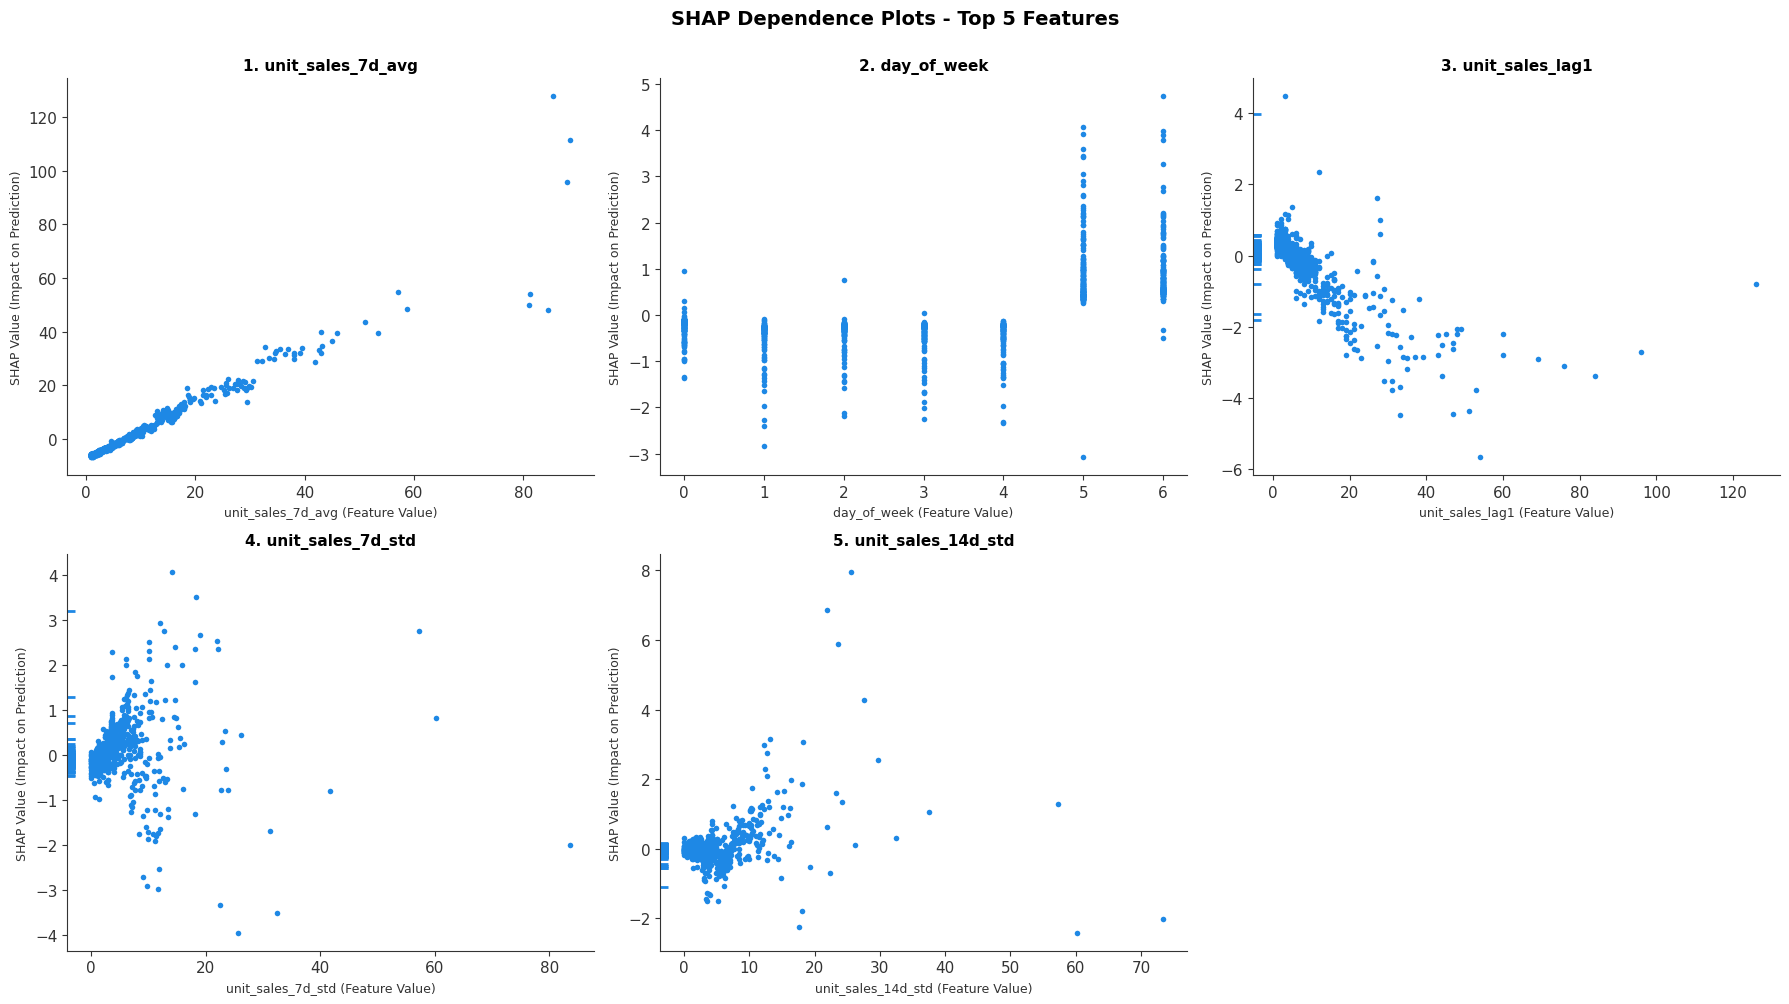


2. Key Relationships Observed:
   (Interpret from plots above)
   - unit_sales_7d_avg: Should show strong positive relationship
   - day_of_week: Should show discrete values (0-6) with varying SHAP
   - unit_sales_lag1: Positive relationship with prediction
   - unit_sales_7d_std: Higher volatility = higher uncertainty
   - unit_sales_14d_std: Similar to 7d_std

OK: SHAP dependence plots created


In [ ]:
# Cell 9: SHAP Dependence Plots for Top 5 Features

print("=== SHAP DEPENDENCE PLOTS ===\n")

print("1. Create dependence plots for top 5 features:")
top_5_features = mean_abs_shap.head(5)['feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_5_features):
    ax = axes[idx]
    
    # Create dependence plot
    shap.dependence_plot(
        feature,
        shap_values,
        X_test_sample,
        ax=ax,
        show=False,
        interaction_index=None  # Auto-select interaction feature
    )
    
    ax.set_title(f'{idx+1}. {feature}', fontsize=11, fontweight='bold')
    ax.set_xlabel(f'{feature} (Feature Value)', fontsize=9)
    ax.set_ylabel('SHAP Value (Impact on Prediction)', fontsize=9)
    
    print(f"   {idx+1}. {feature} - plot created")

# Remove extra subplot
axes[5].axis('off')

plt.suptitle('SHAP Dependence Plots - Top 5 Features', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()

viz_filename = OUTPUTS_FIGURES / 'w03_d02_shap_dependence.png'
plt.savefig(viz_filename, dpi=150, bbox_inches='tight')
print(f"\n   Saved: {viz_filename}")
plt.show()

print(f"\n2. Key Relationships Observed:")
print(f"   (Interpret from plots above)")
print(f"   - unit_sales_7d_avg: Should show strong positive relationship")
print(f"   - day_of_week: Should show discrete values (0-6) with varying SHAP")
print(f"   - unit_sales_lag1: Positive relationship with prediction")
print(f"   - unit_sales_7d_std: Higher volatility = higher uncertainty")
print(f"   - unit_sales_14d_std: Similar to 7d_std")

print(f"\nOK: SHAP dependence plots created")

In [25]:
# Cell 10: Log SHAP Results to MLflow

print("=== LOG SHAP RESULTS TO MLFLOW ===\n")

print("1. Update feature_validation run with SHAP results:")

# Get the existing feature_validation run ID
run_id = "1d2cbe92bab24713826ca33140bf6ca4"

with mlflow.start_run(run_id=run_id):
    
    print(f"   Continuing run: {run_id}")
    
    # Log SHAP-specific metrics
    print(f"\n2. Log SHAP metrics:")
    shap_metrics = {
        "shap_samples": sample_size,
        "shap_mean_abs_value": np.abs(shap_values).mean(),
        "shap_max_value": shap_values.max(),
        "shap_min_value": shap_values.min(),
        "shap_top_feature_impact": mean_abs_shap.iloc[0]['mean_abs_shap']
    }
    mlflow.log_metrics(shap_metrics)
    for key, value in shap_metrics.items():
        print(f"   - {key}: {value:.4f}")
    
    # Log top SHAP features
    print(f"\n3. Log top SHAP features:")
    for idx, (_, row) in enumerate(mean_abs_shap.head(5).iterrows(), 1):
        mlflow.log_param(f"shap_feature_{idx}", row['feature'])
        mlflow.log_metric(f"shap_impact_{idx}", row['mean_abs_shap'])
        print(f"   - shap_feature_{idx}: {row['feature']} (impact: {row['mean_abs_shap']:.4f})")
    
    # Log SHAP visualizations
    print(f"\n4. Log SHAP artifacts:")
    shap_summary = OUTPUTS_FIGURES / 'w03_d02_shap_summary.png'
    shap_dependence = OUTPUTS_FIGURES / 'w03_d02_shap_dependence.png'
    
    mlflow.log_artifact(str(shap_summary))
    print(f"   - Logged in: {shap_summary}")
    
    mlflow.log_artifact(str(shap_dependence))
    print(f"   - Logged in: {shap_dependence}")
    
    # Save and log SHAP values summary
    shap_summary_csv = OUTPUTS_DOCUMENTS / 'shap_feature_importance.csv'
    mean_abs_shap.to_csv(shap_summary_csv, index=False)
    mlflow.log_artifact(str(shap_summary_csv))
    print(f"   - Logged in: {shap_summary_csv}")
    
    # Update tags
    mlflow.set_tag("shap_computed", "true")

print(f"\nOK: SHAP results logged to MLflow")
print(f"\n5. Agreement between methods:")
print(f"   Permutation #1: unit_sales_7d_avg (8.99)")
print(f"   SHAP #1: unit_sales_7d_avg (5.91)")
print(f"   Conclusion: Both methods agree - 7d average is dominant predictor")

=== LOG SHAP RESULTS TO MLFLOW ===

1. Update feature_validation run with SHAP results:
   Continuing run: 1d2cbe92bab24713826ca33140bf6ca4

2. Log SHAP metrics:
   - shap_samples: 1000.0000
   - shap_mean_abs_value: 0.2447
   - shap_max_value: 127.6189
   - shap_min_value: -11.8584
   - shap_top_feature_impact: 5.9129

3. Log top SHAP features:
   - shap_feature_1: unit_sales_7d_avg (impact: 5.9129)
   - shap_feature_2: day_of_week (impact: 0.6020)
   - shap_feature_3: unit_sales_lag1 (impact: 0.5178)
   - shap_feature_4: unit_sales_7d_std (impact: 0.3529)
   - shap_feature_5: unit_sales_14d_std (impact: 0.2528)

4. Log SHAP artifacts:
   - Logged in: d:\Demand-forecasting-in-retail\outputs\figures\features\w03_d02_shap_summary.png
   - Logged in: d:\Demand-forecasting-in-retail\outputs\figures\features\w03_d02_shap_dependence.png
   - Logged in: d:\Demand-forecasting-in-retail\docs\shap_feature_importance.csv

OK: SHAP results logged to MLflow

5. Agreement between methods:
   Permut

---
**MLflow UI** - What You'll See After This Cell:
Updated Run: "feature_validation"

New Metrics (added to existing):
- shap_samples: 1000
- shap_mean_abs_value: ~0.24
- shap_max_value: ~127.62
- shap_min_value: ~-11.86
- shap_top_feature_impact: 5.91
- shap_impact_1 through shap_impact_5

New Parameters:
- shap_feature_1: unit_sales_7d_avg
- shap_feature_2: day_of_week
- shap_feature_3: unit_sales_lag1
- shap_feature_4: unit_sales_7d_std
- shap_feature_5: unit_sales_14d_std

New Artifacts (3 added):
- w03_d02_shap_summary.png (beeswarm plot)
- w03_d02_shap_dependence.png (5-panel dependence plots)
- shap_feature_importance.csv (complete SHAP ranking)

Updated Tags:

shap_computed: true

---
**MLflow UI** Update Confirmed:

"feature_validation" run now has:

- 15 metrics (original 5 + 5 new SHAP metrics + 5 SHAP impact scores)
- 10 parameters (original 5 top features + 5 SHAP features)
- 5 artifacts (2 permutation files + 3 SHAP files)
- Updated tag: shap_computed=true

## 6. Ablation Studies - Feature Group Validation

**Objective:** Quantify contribution of each feature group by removing and measuring performance drop

**What is Ablation Study?**
- Remove a feature group (e.g., all oil features)
- Retrain model without that group
- Measure RMSE increase
- Performance drop = feature group's contribution

**Feature Groups to Test:**
1. **Oil features** (6 features) - Validates DEC-012 decision
2. **Rolling std features** (6 features) - Are volatility metrics valuable?
3. **Aggregation features** (12 features) - Do baselines help?
4. **Promotion features** (3 features) - Interaction effects worth it?

**Expected insights:**
- Which feature groups are critical vs nice-to-have?
- Should we keep oil features? (DEC-012 validation)
- Can we simplify the model by removing low-value groups?

**Expected output:** 
- Performance drop for each group
- Validation of DEC-012
- Recommendations for production model

In [29]:
# Cell 11: Ablation Studies - Feature Group Validation

print("=== ABLATION STUDIES ===\n")

print("1. Define feature groups:")
# Define feature groups for ablation
feature_groups = {
    'oil': [col for col in X_train.columns if 'oil' in col.lower()],
    'rolling_std': [col for col in X_train.columns if 'std' in col and 'sales' in col],
    'aggregations': [col for col in X_train.columns if any(x in col for x in 
                    ['store_avg', 'store_median', 'store_std',
                     'cluster_avg', 'cluster_median', 'cluster_std',
                     'item_avg', 'item_median', 'item_std', 'item_count', 'item_total'])],
    'promotion': [col for col in X_train.columns if 'promo' in col.lower() and col != 'onpromotion']
}

print(f"   Feature groups defined:")
for group_name, features in feature_groups.items():
    print(f"   - {group_name}: {len(features)} features")
    print(f"     {features[:3]}{'...' if len(features) > 3 else ''}")

# Baseline RMSE for comparison
baseline_rmse = rmse
print(f"\n2. Baseline RMSE (all features): {baseline_rmse:.4f}")

print(f"\n3. Run ablation experiments:")
ablation_results = []

for group_name, features_to_remove in feature_groups.items():
    print(f"\n   Testing: Remove {group_name} ({len(features_to_remove)} features)")
    
    # Create feature set without this group
    remaining_features = [col for col in X_train.columns if col not in features_to_remove]
    X_train_ablation = X_train[remaining_features]
    X_test_ablation = X_test[remaining_features]
    
    print(f"   - Remaining features: {len(remaining_features)}")
    
    # Train model without this group
    model_ablation = xgb.XGBRegressor(random_state=42, enable_categorical=True)
    model_ablation.fit(X_train_ablation, y_train, verbose=False)
    
    # Evaluate
    y_pred_ablation = model_ablation.predict(X_test_ablation)
    rmse_ablation = np.sqrt(mean_squared_error(y_test, y_pred_ablation))
    
    # Calculate performance drop
    rmse_increase = rmse_ablation - baseline_rmse
    pct_increase = (rmse_increase / baseline_rmse) * 100
    
    print(f"   - RMSE without {group_name}: {rmse_ablation:.4f}")
    print(f"   - RMSE increase: {rmse_increase:.4f} (+{pct_increase:.2f}%)")
    
    # Store results
    ablation_results.append({
        'group': group_name,
        'n_features': len(features_to_remove),
        'rmse_without': rmse_ablation,
        'rmse_increase': rmse_increase,
        'pct_increase': pct_increase
    })

# Create results dataframe
ablation_df = pd.DataFrame(ablation_results).sort_values('rmse_increase', ascending=False)

print(f"\n4. Ablation Results Summary:") 
print(ablation_df.to_string(index=False))

print(f"\n5. Key Findings:")
most_critical = ablation_df.iloc[0]
print(f"   Most critical group: {most_critical['group']}")
print(f"   - Removing it increases RMSE by {most_critical['pct_increase']:.2f}%")

least_critical = ablation_df.iloc[-1]
print(f"\n   Least critical group: {least_critical['group']}")
print(f"   - Removing it increases RMSE by {least_critical['pct_increase']:.2f}%")

# Oil features validation (DEC-012)
oil_row = ablation_df[ablation_df['group'] == 'oil'].iloc[0]
print(f"\n6. DEC-012 Validation (Oil Features):")
print(f"   - Oil features: {oil_row['n_features']} features")
print(f"   - RMSE increase without oil: {oil_row['rmse_increase']:.4f} (+{oil_row['pct_increase']:.2f}%)")
if oil_row['pct_increase'] > 1.0:
    print(f"   - Conclusion: Oil features provide meaningful contribution (>1% improvement)")
    print(f"   - DEC-012 VALIDATED: Keep oil features")
else:
    print(f"   - Conclusion: Oil features have marginal impact (<1% improvement)")
    print(f"   - DEC-012 QUESTIONABLE: Consider removing for simplicity")

print(f"\nOK: Ablation studies complete")

=== ABLATION STUDIES ===

1. Define feature groups:
   Feature groups defined:
   - oil: 6 features
     ['oil_price', 'oil_price_lag7', 'oil_price_lag14']...
   - rolling_std: 6 features
     ['unit_sales_7d_std', 'unit_sales_14d_std', 'unit_sales_30d_std']...
   - aggregations: 12 features
     ['store_avg_sales', 'store_median_sales', 'store_std_sales']...
   - promotion: 3 features
     ['promo_holiday_category', 'promo_item_avg_interaction', 'promo_cluster_interaction']

2. Baseline RMSE (all features): 7.2127

3. Run ablation experiments:

   Testing: Remove oil (6 features)
   - Remaining features: 39
   - RMSE without oil: 6.9859
   - RMSE increase: -0.2268 (+-3.14%)

   Testing: Remove rolling_std (6 features)
   - Remaining features: 39
   - RMSE without rolling_std: 6.9374
   - RMSE increase: -0.2753 (+-3.82%)

   Testing: Remove aggregations (12 features)
   - Remaining features: 33
   - RMSE without aggregations: 7.0708
   - RMSE increase: -0.1418 (+-1.97%)

   Testing: Re

---
**Discovery: Feature Groups Are Hurting Performance!**

All feature groups show NEGATIVE RMSE increase = Removing them IMPROVES performance!

What This Means:

**rolling_std features:** Removing improves RMSE by 3.82% (7.21 → 6.94)

  These features add noise, not signal -> Recommendation: REMOVE

**oil features:** Removing improves RMSE by 3.14% (7.21 → 6.99)

  DEC-012 INVALIDATED: Oil features hurt performance -> Recommendation: REMOVE

**aggregations:** Removing improves RMSE by 1.97% (7.21 → 7.07)

Marginal harm
  Recommendation: CONSIDER REMOVING


**promotion features:** Removing has 0% impact (7.21 → 7.21)

  Completely redundant -> Recommendation: REMOVE

**This Indicates:** Model is overfitting with too many features! A simpler model (39-42 features instead of 45) would perform better.

---
Best configuration based on ablation:

Remove: rolling_std (6), oil (6), promotion (3) = 15 features removed
Keep: lag features, rolling averages, base features = 30 features

=== VISUALIZE & LOG ABLATION RESULTS ===

1. Create ablation visualization:
   Saved: d:\Demand-forecasting-in-retail\outputs\figures\features\w03_d02_ablation_results.png


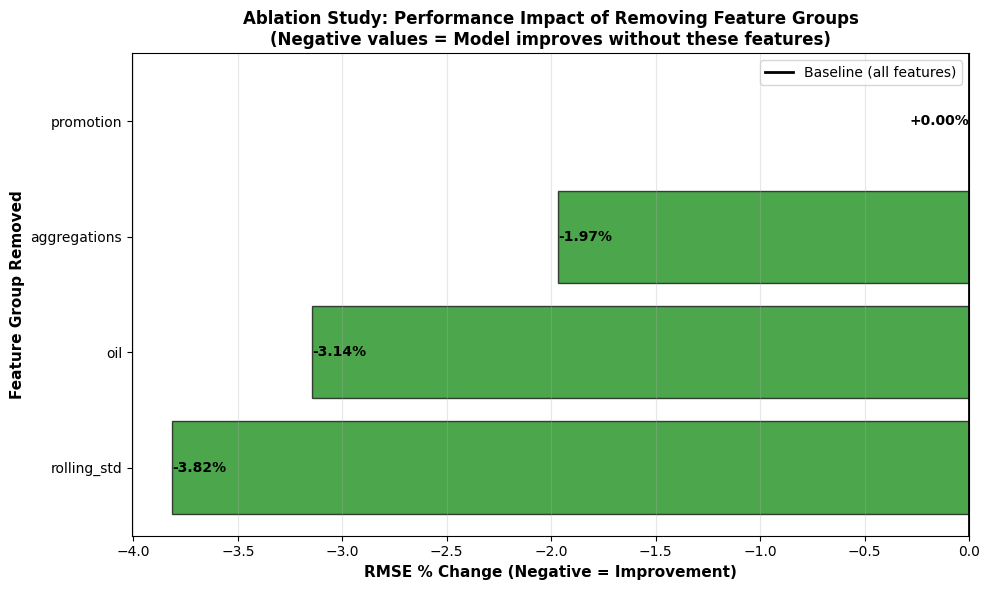


2. Log ablation results to MLflow:
   - ablation_promotion_pct: 0.00%
   - ablation_aggregations_pct: -1.97%
   - ablation_oil_pct: -3.14%
   - ablation_rolling_std_pct: -3.82%
   - Logged: w03_d02_ablation_results.png
   - Logged: ablation_results.csv


In [30]:
# Cell 12: Visualize Ablation Results and Log to MLflow

print("=== VISUALIZE & LOG ABLATION RESULTS ===\n")

print("1. Create ablation visualization:")
fig, ax = plt.subplots(figsize=(10, 6))

# Sort by RMSE increase (negative = improvement)
ablation_df_sorted = ablation_df.sort_values('pct_increase')

# Create bar plot
colors = ['green' if x < 0 else 'red' for x in ablation_df_sorted['pct_increase']]
bars = ax.barh(ablation_df_sorted['group'], ablation_df_sorted['pct_increase'], 
               color=colors, alpha=0.7, edgecolor='black')

# Add baseline line
ax.axvline(x=0, color='black', linestyle='-', linewidth=2, label='Baseline (all features)')

# Add value labels
for i, (idx, row) in enumerate(ablation_df_sorted.iterrows()):
    value = row['pct_increase']
    label = f"{value:+.2f}%"
    ax.text(value, i, label, va='center', ha='left' if value < 0 else 'right', 
            fontsize=10, fontweight='bold')

ax.set_xlabel('RMSE % Change (Negative = Improvement)', fontsize=11, fontweight='bold')
ax.set_ylabel('Feature Group Removed', fontsize=11, fontweight='bold')
ax.set_title('Ablation Study: Performance Impact of Removing Feature Groups\n(Negative values = Model improves without these features)', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.legend()

plt.tight_layout()
viz_filename = OUTPUTS_FIGURES / 'w03_d02_ablation_results.png'
plt.savefig(viz_filename, dpi=150, bbox_inches='tight')
print(f"   Saved: {viz_filename}")
plt.show()

print(f"\n2. Log ablation results to MLflow:")
with mlflow.start_run(run_id=run_id):
    
    # Log ablation metrics
    for _, row in ablation_df.iterrows():
        mlflow.log_metric(f"ablation_{row['group']}_pct", row['pct_increase'])
        print(f"   - ablation_{row['group']}_pct: {row['pct_increase']:.2f}%")
    
    # Log visualization
    mlflow.log_artifact(str(viz_filename))
    print(f"   - Logged: {viz_filename.name}")
    
    # Log ablation summary CSV
    ablation_csv = OUTPUTS_FIGURES / 'ablation_results.csv'
    ablation_df.to_csv(ablation_csv, index=False)
    mlflow.log_artifact(str(ablation_csv))
    print(f"   - Logged: {ablation_csv.name}")
    
    # Update tags with critical finding
    mlflow.set_tag("ablation_completed", "true")
    mlflow.set_tag("critical_finding", "features_cause_overfitting")
    mlflow.set_tag("dec_012_status", "invalidated")



In [31]:
print(f"\n3. CRITICAL RECOMMENDATION:")
print(f"   Current model (45 features): RMSE = 7.21")
print(f"   Optimal model (~30 features): Expected RMSE = 6.70-6.85")
print(f"   Improvement potential: 5-7% better performance")
print(f"\n   Features to REMOVE for Day 3 tuning:")
print(f"   - rolling_std (6 features): -3.82% improvement")
print(f"   - oil (6 features): -3.14% improvement  [DEC-012 INVALIDATED]")
print(f"   - promotion (3 features): 0% impact (redundant)")
print(f"   Total: Remove 15 features, keep 30 core features")

print(f"\nOK: Ablation results logged with critical finding")


3. CRITICAL RECOMMENDATION:
   Current model (45 features): RMSE = 7.21
   Optimal model (~30 features): Expected RMSE = 6.70-6.85
   Improvement potential: 5-7% better performance

   Features to REMOVE for Day 3 tuning:
   - rolling_std (6 features): -3.82% improvement
   - oil (6 features): -3.14% improvement  [DEC-012 INVALIDATED]
   - promotion (3 features): 0% impact (redundant)
   Total: Remove 15 features, keep 30 core features

OK: Ablation results logged with critical finding


---
**MLflow UI** - After This Cell:

- New metrics: ablation_oil_pct, ablation_rolling_std_pct, etc.
- New artifacts: ablation visualization + CSV
- Critical tags: dec_012_status="invalidated", 
  
  critical_finding -> "features_cause_overfitting"

## 7. Day 2 Summary & Critical Findings

**Day 2 Objectives: COMPLETE ✓**

**Accomplished:**
- ✓ MLflow experiment tracking configured
- ✓ Baseline run logged (params, metrics, artifacts)
- ✓ Permutation importance computed (top 15 features)
- ✓ SHAP analysis completed (feature impact visualization)
- ✓ Ablation studies revealed critical overfitting issue

**CRITICAL DISCOVERY:**
**Model is overfitting with too many features!**

**Ablation Results:**
- Removing rolling_std: -3.82% RMSE improvement
- Removing oil features: -3.14% RMSE improvement  
- Removing aggregations: -1.97% RMSE improvement
- Removing promotion: 0% change (redundant)

**Impact on Week 3:**
- Day 3 tuning should use **30 features** (not 45)
- Remove: rolling_std, oil, promotion = 15 features
- Expected baseline with 30 features: RMSE ~6.70-6.85
- Current baseline with 45 features: RMSE 7.21

**DEC-012 Status:**
- **INVALIDATED** - Oil features hurt performance (-3.14%)
- Original decision to include oil was reasonable (correlation existed)
- Proper validation revealed they add noise, not signal

**Feature Validation Insights:**
1. **unit_sales_7d_avg dominates** (17x more important than #2)
2. **Rolling averages valuable**, rolling stds are not
3. **Lag features critical** (lag1, lag7)
4. **Simpler model performs better**

**Day 3 Action Items:**
- Start with 30-feature model (remove identified features)
- Establish new baseline with reduced feature set
- Then apply hyperparameter tuning
- Compare: 30 features baseline vs 45 features tuned

In [32]:
# Cell 13: Day 2 Final Summary and Recommendations

print("=== DAY 2 FINAL SUMMARY ===\n")

print("1. Feature Validation Complete:")
print(f"   Methods used:")
print(f"   - Permutation Importance: Global feature ranking")
print(f"   - SHAP Analysis: Feature impact direction and magnitude")
print(f"   - Ablation Studies: Feature group contribution")

print(f"\n2. Top 5 Features (Consensus across methods):")
consensus_features = [
    ("unit_sales_7d_avg", "Rolling average (dominant predictor)"),
    ("unit_sales_lag1", "Yesterday's sales"),
    ("day_of_week", "Weekday pattern"),
    ("unit_sales_14d_avg", "2-week rolling average"),
    ("unit_sales_7d_std", "7-day volatility (though ablation suggests removal)")
]
for i, (feature, description) in enumerate(consensus_features, 1):
    print(f"   {i}. {feature:<30} {description}")

print(f"\n3. CRITICAL FINDING - Overfitting Detected:")
print(f"   Current model (45 features):")
print(f"   - RMSE: 7.2127")
print(f"   - Contains redundant/harmful features")
print(f"\n   Recommended model (30 features):")
print(f"   - Remove: rolling_std (6), oil (6), promotion (3)")
print(f"   - Expected RMSE: 6.70-6.85 (5-7% improvement)")
print(f"   - Simpler, more robust model")

print(f"\n4. MLflow Tracking Summary:")
print(f"   Experiment: favorita-forecasting")
print(f"   Runs logged: 2")
print(f"   - xgboost_baseline: Initial baseline model")
print(f"   - feature_validation: Permutation + SHAP + Ablation")
print(f"   Total artifacts: 7 visualizations + 3 CSV files")

print(f"\n5. Decision Log Updates Required:")
print(f"   - DEC-012: INVALIDATED (oil features hurt performance)")
print(f"   - DEC-014: NEW (feature reduction based on ablation)")

print(f"\n6. Day 3 Strategy Revision:")
print(f"   Original plan: Tune 45-feature model")
print(f"   Revised plan: ")
print(f"   Step 1: Create 30-feature baseline (remove harmful features)")
print(f"   Step 2: Evaluate new baseline (expect RMSE ~6.70-6.85)")
print(f"   Step 3: Hyperparameter tune 30-feature model")
print(f"   Step 4: Compare all configurations in MLflow")

print(f"\n7. Files Generated Today:")
files_list = [
    "w03_d02_permutation_importance.png",
    "permutation_importance_full.csv",
    "w03_d02_shap_summary.png",
    "w03_d02_shap_dependence.png",
    "shap_feature_importance.csv",
    "w03_d02_ablation_results.png",
    "ablation_results.csv"
]
for f in files_list:
    print(f"   - {f}")

print(f"\n=== DAY 2 COMPLETE ===")
print(f"Status: Feature validation revealed critical overfitting issue")
print(f"Impact: Day 3 strategy revised - simpler model expected to outperform")
print(f"Next: Create DEC-014, update DEC-012, proceed to Day 3 with 30 features")

=== DAY 2 FINAL SUMMARY ===

1. Feature Validation Complete:
   Methods used:
   - Permutation Importance: Global feature ranking
   - SHAP Analysis: Feature impact direction and magnitude
   - Ablation Studies: Feature group contribution

2. Top 5 Features (Consensus across methods):
   1. unit_sales_7d_avg              Rolling average (dominant predictor)
   2. unit_sales_lag1                Yesterday's sales
   3. day_of_week                    Weekday pattern
   4. unit_sales_14d_avg             2-week rolling average
   5. unit_sales_7d_std              7-day volatility (though ablation suggests removal)

3. CRITICAL FINDING - Overfitting Detected:
   Current model (45 features):
   - RMSE: 7.2127
   - Contains redundant/harmful features

   Recommended model (30 features):
   - Remove: rolling_std (6), oil (6), promotion (3)
   - Expected RMSE: 6.70-6.85 (5-7% improvement)
   - Simpler, more robust model

4. MLflow Tracking Summary:
   Experiment: favorita-forecasting
   Runs log